In [1]:
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:

glpe_runs = mlflow.search_runs(experiment_ids=['2']).fillna(value=np.nan)

cepa_runs = mlflow.search_runs(experiment_ids=['0']).fillna(value=np.nan)

In [3]:
def get_max_config(df: pd.DataFrame, method: str) -> pd.DataFrame:
    '''
    get the best runs for a method by experiment
    '''
    query = df['params.method'] == method
    method_runs = df[query]

    best_runs = pd.DataFrame(columns = df.columns)

    for experiment in np.unique(method_runs['params.experiment']):

        best_run = load_best_run(experiment, method_runs)

        best_runs = best_runs.append(best_run, ignore_index = True)

    return best_runs

def get_precomputed_directed_pagerank(df: pd.DataFrame) -> pd.DataFrame:
    query = (df['params.method'] == 'CPE') &\
            (df['params.centrality_measure'] == 'page_rank') &\
            (df['params.similarity_measure'] == 'precomputed') &\
            (df['params.directed'] == 'True')
    good_cpe_runs = df[query]

    return good_cpe_runs

def load_best_run(experiment: str, method_runs: pd.DataFrame) -> pd.DataFrame:
    '''
    index highest BSR mlflow run by an experiment
    '''
    query = method_runs['params.experiment'] == experiment
    exp_method_runs = method_runs[query]
    max_idx = exp_method_runs['metrics.train_test.Test.Mean.BSR'].idxmax()    
    best_run = exp_method_runs.loc[max_idx]

    return best_run

def get_pathways_glpe(exp_id: str, best_runs: pd.DataFrame) -> list:
    '''
    get the glpe pathways that were selected in feature selection
    '''
    # import IPython; IPython.embed()

    query = best_runs['params.experiment'] == exp_id
    run = best_runs[query]
    pathways = pd.read_csv(os.path.join(run.filter(regex='artifact').iloc[0,0], 'pathway_ranks.csv'), dtype=object).dropna(how = 'all')
    pathways['batch:Ranks'] = pathways['batch:Ranks'].astype(int)
    selected_pathways = pathways[pathways['batch:Selected'] == '1']
    pathway_list = list(selected_pathways['Unnamed: 0'])
    return pathway_list

def get_cepa_query(best_cpe_runs: pd.DataFrame, cepa_runs: pd.DataFrame, exp_id: str) -> pd.Series:
    '''
    query cepa using cpe run and experiment id
    '''

    query = best_cpe_runs['params.experiment'] == exp_id
    cpe_run  = best_cpe_runs[query]
    similarity_measure = cpe_run['params.similarity_measure'].item()
    centrality_measure = cpe_run['params.centrality_measure'].item()

    query = limma_query_switch(exp_id, cepa_runs, similarity_measure, centrality_measure)

    return query
    
def limma_query_switch(exp_id: str, cepa_runs: pd.DataFrame, similarity_measure: str, centrality_measure: str) -> pd.Series:
    '''
    generate a query for cepa using cpe centrality_measure, similarity_measure and exp_id
    ''' 
    query = (cepa_runs['params.centrality_measure'] == centrality_measure) & \
            (cepa_runs['params.similarity_measure'] == similarity_measure) & \
            (cepa_runs['params.experiment'] == exp_id) & \
            (cepa_runs['params.directed'] == 'False')

    return query

def get_pathways_cepa(best_cpe_runs: pd.DataFrame, exp_id: str, cepa_runs: pd.DataFrame, pval_thresh =.05) -> list:
    '''
    get cepa pathways using experiment, score, and p value threshhold
    '''
    query = get_cepa_query(best_cpe_runs, cepa_runs, exp_id)

    run = cepa_runs[query]

    pathways = pd.read_csv(os.path.join(run['artifact_uri'].item(), 'cpe_pathway_ranks.csv'), dtype=object)
    pathways['p_val'] = pathways['p_val'].astype(float)
    # pathways = pathways.sort_values(by = 'p_val')
    pathways = pathways.sort_values(by = 'score', ascending = False)
    best_pathways = pathways.query("p_val< @pval_thresh")
    cepa_pathways = list(best_pathways.iloc[:60]['ReactomeID'])

    return cepa_pathways

def jaccard(list1 : list, list2: list) -> float:
    '''
    find the jaccard overlap
    '''
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union


In [4]:
best_cpe_runs = get_precomputed_directed_pagerank(glpe_runs)
best_lpe_runs = get_max_config(glpe_runs, 'LPE')


/tmp/ipykernel_40707/2243643634.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_runs = best_runs.append(best_run, ignore_index = True)
/tmp/ipykernel_40707/2243643634.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_runs = best_runs.append(best_run, ignore_index = True)
/tmp/ipykernel_40707/2243643634.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_runs = best_runs.append(best_run, ignore_index = True)
/tmp/ipykernel_40707/2243643634.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_runs = best_runs.append(best_run, ignore_index = True)
/tmp/ipykernel_40707/2243643634.py:14: FutureWarning: The frame.

In [41]:
overlap_data = pd.DataFrame(columns = ['Method','Time Bin', 'Overlap'])
for t_bin in ['1_8','9_16', '17_24', '25_32']:
    exp_id4 = f'gse73072_4to2_{t_bin}_subjectID_limma'
    exp_id6 = f'gse73072_6to1_{t_bin}_subjectID_limma'

    cpe4_pathway_list = get_pathways_glpe(exp_id4, best_cpe_runs)
    lpe4_pathway_list = get_pathways_glpe(exp_id4, best_lpe_runs)

    cpe6_pathway_list = get_pathways_glpe(exp_id6, best_cpe_runs)
    lpe6_pathway_list = get_pathways_glpe(exp_id6, best_lpe_runs)

    ora_pathways_df = pd.read_csv(f'../ge_ora/{exp_id4}.csv', index_col = 0)
    ora_query = ora_pathways_df['pvalue'] < 1 #1 pvalue threshold for ORA
    ora4_pathway_list = set(list(ora_pathways_df[ora_query]['ID']))

    ora_pathways_df = pd.read_csv(f'../ge_ora/{exp_id6}.csv', index_col = 0)
    ora_query = ora_pathways_df['pvalue'] < 1 #1 pvalue threshold for ORA
    ora6_pathway_list = set(list(ora_pathways_df[ora_query]['ID']))

    cepa4_pathway_list = get_pathways_cepa(best_cpe_runs, exp_id4, cepa_runs, pval_thresh =.05)
    cepa6_pathway_list = get_pathways_cepa(best_cpe_runs, exp_id6, cepa_runs, pval_thresh =.05)


    cpe_overlap = jaccard(cpe4_pathway_list,cpe6_pathway_list)
    lpe_overlap = jaccard(lpe4_pathway_list,lpe6_pathway_list)
    cepa_overlap = jaccard(cepa4_pathway_list, cepa6_pathway_list)
    ora_overlap = jaccard(ora4_pathway_list,ora6_pathway_list)

    row = pd.DataFrame(columns = ['Method','Time Bin', 'Overlap'], data = [['CPE', t_bin, cpe_overlap]])
    overlap_data = pd.concat([overlap_data, row])
    row = pd.DataFrame(columns = ['Method','Time Bin', 'Overlap'], data = [['LPE', t_bin, lpe_overlap]])
    overlap_data = pd.concat([overlap_data, row])
    row = pd.DataFrame(columns = ['Method','Time Bin', 'Overlap'], data = [['CEPA', t_bin, cepa_overlap]])
    overlap_data = pd.concat([overlap_data, row])
    row = pd.DataFrame(columns = ['Method','Time Bin', 'Overlap'], data = [['ORA', t_bin, ora_overlap]])
    overlap_data = pd.concat([overlap_data, row])



In [46]:
overlap_data

,Method,Time Bin,Overlap
0,CPE,1_8,0.087719
0,LPE,1_8,0.058824
0,CEPA,1_8,0.016949
0,ORA,1_8,0.209524
0,CPE,9_16,0.101449
0,LPE,9_16,0.088542
0,CEPA,9_16,0.016949
0,ORA,9_16,0.22884
0,CPE,17_24,0.140794
0,LPE,17_24,0.118644


<AxesSubplot:>

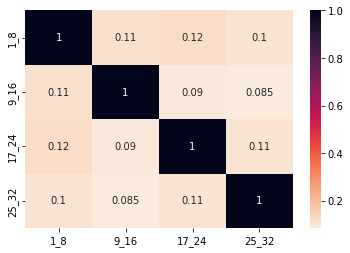

In [45]:
time_overlap = pd.DataFrame(columns = ['1_8','9_16', '17_24', '25_32'], index= ['1_8','9_16', '17_24', '25_32'])

for t_bin1 in ['1_8','9_16', '17_24', '25_32']:
    for t_bin2 in ['1_8','9_16', '17_24', '25_32']:
        exp_id1 = f'gse73072_6to1_{t_bin1}_subjectID_limma'
        exp_id2 = f'gse73072_6to1_{t_bin2}_subjectID_limma'

        cpe1_pathway_list = get_pathways_glpe(exp_id1, best_lpe_runs)
        cpe2_pathway_list = get_pathways_glpe(exp_id2, best_lpe_runs)

        time_overlap.loc[t_bin1, t_bin2] = jaccard(cpe1_pathway_list, cpe2_pathway_list)
        time_overlap.loc[t_bin2, t_bin1] = time_overlap.loc[t_bin1, t_bin2]

sns.heatmap(data = time_overlap.astype(float),annot=True, cmap = "rocket_r")


<AxesSubplot:>

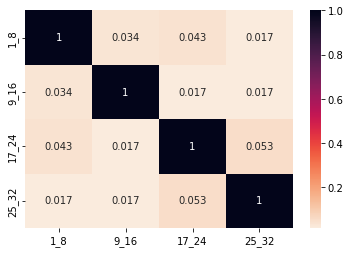

In [47]:
time_overlap = pd.DataFrame(columns = ['1_8','9_16', '17_24', '25_32'], index= ['1_8','9_16', '17_24', '25_32'])

for t_bin1 in ['1_8','9_16', '17_24', '25_32']:
    for t_bin2 in ['1_8','9_16', '17_24', '25_32']:
        exp_id1 = f'gse73072_6to1_{t_bin1}_subjectID_limma'
        exp_id2 = f'gse73072_6to1_{t_bin2}_subjectID_limma'


        cepa1_pathway_list = get_pathways_cepa(best_cpe_runs, exp_id1, cepa_runs, pval_thresh =.05)
        cepa2_pathway_list = get_pathways_cepa(best_cpe_runs, exp_id2, cepa_runs, pval_thresh =.05)

        time_overlap.loc[t_bin1, t_bin2] = jaccard(cepa1_pathway_list, cepa2_pathway_list)
        time_overlap.loc[t_bin2, t_bin1] = time_overlap.loc[t_bin1, t_bin2]



sns.heatmap(data = time_overlap.astype(float),annot=True, cmap = "rocket_r")

<AxesSubplot:>

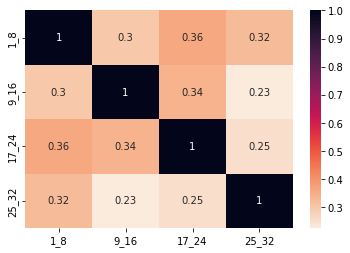

In [48]:
time_overlap = pd.DataFrame(columns = ['1_8','9_16', '17_24', '25_32'], index= ['1_8','9_16', '17_24', '25_32'])

for t_bin1 in ['1_8','9_16', '17_24', '25_32']:
    for t_bin2 in ['1_8','9_16', '17_24', '25_32']:
        exp_id1 = f'gse73072_6to1_{t_bin1}_subjectID_limma'
        exp_id2 = f'gse73072_6to1_{t_bin2}_subjectID_limma'


        ora_pathways_df = pd.read_csv(f'../ge_ora/{exp_id1}.csv', index_col = 0)
        ora_query = ora_pathways_df['pvalue'] < 1 #1 pvalue threshold for ORA
        ora1_pathway_list = set(list(ora_pathways_df[ora_query]['ID']))

        ora_pathways_df = pd.read_csv(f'../ge_ora/{exp_id2}.csv', index_col = 0)
        ora_query = ora_pathways_df['pvalue'] < 1 #1 pvalue threshold for ORA
        ora2_pathway_list = set(list(ora_pathways_df[ora_query]['ID']))

        time_overlap.loc[t_bin1, t_bin2] = jaccard(ora1_pathway_list, ora2_pathway_list)
        time_overlap.loc[t_bin2, t_bin1] = time_overlap.loc[t_bin1, t_bin2]



sns.heatmap(data = time_overlap.astype(float),annot=True, cmap = "rocket_r")